In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# EDA

### A little exploration of the data, including:

* Districts distribution and demography
* Top digital learning products by engagement
* Engangement in top products across 2020 in different demographies.

In [2]:
library(tidyverse)
library(janitor)
library(here)
library(scico)
library(usmap)
library(viridis)
library(patchwork)
library(skimr)
library(DataExplorer)
library(lubridate)
library(ggthemes)
library(corrplot)
theme_set(theme_minimal())

In [3]:
input_path <- here("../input", "learnplatform-covid19-impact-on-digital-learning")

In [4]:
#reformatting variables
reformat_col <- function(pct) {
        out <- pct %>% 
                str_split(",") %>% 
                map(str_remove, "\\[") %>% 
                map(function(x) paste(as.numeric(x) * 100, collapse = "-")) %>% 
                unlist() 
        # making NAs proper NAs
        out[out == "NA"] <- NA
        out
}

## Districts

In [5]:
districts <- read_csv(here(input_path, "districts_info.csv"), na = c("", "NaN")) %>% 
        clean_names() %>% 
        mutate(across(starts_with("pct"), ~ reformat_col(.x)),
               pp_total_raw = str_remove_all(pp_total_raw, "\\["),
               pp_total_raw = str_replace(pp_total_raw, ", ", "-"))
districts <-districts %>% clean_names()
districts[1:10,]

### Distriction Information

In [6]:
p1 <- districts %>% 
        filter(!is.na(pct_black_hispanic)) %>% 
        mutate(pct_black_hispanic = fct_rev(pct_black_hispanic)) %>% 
        ggplot(aes(locale, fill = pct_black_hispanic)) +
        geom_bar() +
        scale_colour_brewer(palette = "Paired",name = "% black/\nhispanic") 
p2 <- districts %>% 
        filter(!is.na(pct_free_reduced)) %>% 
        mutate(pct_free_reduced = fct_rev(pct_free_reduced)) %>% 
        ggplot(aes(locale, fill =pct_free_reduced)) +
        geom_bar() +
        scale_colour_brewer(palette = "Paired",name = "% free/\nreduced lunch") 
p3 <- districts %>% 
        filter(!is.na(pp_total_raw)) %>% 
        mutate(pp_total_raw2 = as.numeric(str_extract(pp_total_raw, "^[^-]*[^ -]"))) %>% 
        mutate(pp_total_raw = fct_reorder(pp_total_raw, -pp_total_raw2)) %>% 
        ggplot(aes(locale, fill = pp_total_raw)) +
        geom_bar() +
        scale_colour_brewer(palette = "Paired",name = "Per-pupil\nexpenditure", direction = 1)

In [7]:
options(repr.plot.width = 18, repr.plot.height = 6)
p1 + p2 + p3 +
        plot_annotation(title = 'District demographics by area type') & 
        theme(text = element_text('Lato', size = 20),
              panel.grid = element_blank()) &
        ylab("# districts") &
        xlab("")

Demographic data show that the different area types differ substantially in their proportion of blacks/hispanics and in their proportion of pupils eligible for free or reduced lunch. No very obvious patterns emerge for expenditure per pupil from this barchart.

## Products

The digital learning products are categorized in various ways. Here, we split them in their main-function and sub-function.

Main function of primary categories are:

LC = Learning & Curriculum
CM = Classroom Management,
SDO = School & District Operations

In [8]:
products <- read_csv(here(input_path, "products_info.csv")) %>% 
                clean_names() %>% 
                separate(primary_essential_function, c("main_fun", "sub_fun"),
                         sep = " - ", extra = "merge")
products <- products %>% clean_names()
products[1:10, ]

# Data structure

In [9]:
library(skimr)
skim(districts)

In [10]:
skim(products)

Both data sets contains missing values.
We plot the missing values proportion in each column to know the better picture.

# Missing values

In [11]:
library(DataExplorer)
library(lubridate)
plot_missing(districts, ggtheme = theme_minimal(base_size = 20))

In [12]:
plot_missing(products, ggtheme = theme_minimal(base_size = 20))

The amount of missing data in both data sets is acceptable except **pp_total_raw** column in districts dataframe. 

# Data Cleaning

In [13]:
#cleaning pp_total_raw column
districts <- districts %>%
  separate(pp_total_raw,c("pp_total_raw-low","pp_total_raw-high"))
str(districts)

districts$`pp_total_raw-high` <- as.integer(districts$`pp_total_raw-high`)
districts$`pp_total_raw-low` <- as.integer(districts$`pp_total_raw-low`)
sum(is.na(districts$`pp_total_raw-high`))
sum(is.na(districts$`pp_total_raw-low`))
unique(districts$`pp_total_raw-high`)
unique(districts$`pp_total_raw-low`)

#Decide whether to impute `pp_total_raw-low` with mean or median
 districts %>%
  summarize(avg=mean(districts$`pp_total_raw-low`,na.rm = TRUE),med=median(districts$`pp_total_raw-low`,na.rm = TRUE))

districts <- districts %>%
  mutate(`pp_total_raw-low`=replace(districts$`pp_total_raw-low`,is.na(districts$`pp_total_raw-low`),median(districts$`pp_total_raw-low`,na.rm = TRUE)))

sum(is.na(districts$`pp_total_raw-low`))

#Decide whether to impute pp_total_raw-high with mean or median
 districts %>%
  summarize(avg=mean(districts$`pp_total_raw-high`,na.rm = TRUE),med=median(districts$`pp_total_raw-high`,na.rm = TRUE))

districts <- districts %>%
  mutate(`pp_total_raw-high`=replace(districts$`pp_total_raw-high`,is.na(districts$`pp_total_raw-high`),median(districts$`pp_total_raw-high`,na.rm = TRUE)))

sum(is.na(districts$`pp_total_raw-high`))

library(gt)

districts<- as.data.frame(districts %>%gt() %>% cols_merge_range(`pp_total_raw-low`,`pp_total_raw-high`, sep = "-"))
districts <- subset(districts, select = -c(`pp_total_raw-high`) )
districts <- districts %>%rename(pp_total_raw=`pp_total_raw-low`)
districts[1:10,]

# Data distribution

In [14]:
#Districts
options(repr.plot.height = 14, repr.plot.width = 20)

plot_bar(districts, ggtheme = theme_minimal(base_size = 20))

In [15]:
# Products
options(repr.plot.height = 8, repr.plot.width = 10)

products %>%
select(`sector_s`) %>%
plot_bar(ggtheme = theme_minimal(base_size = 20))

### Districts data distribution

In [16]:
#State
districts %>%
group_by(state) %>%
count() %>%
ggplot(aes(x = reorder(state, n), y = n)) +
geom_bar(stat = "identity", fill = "steelblue") +
labs(x = "State", y = "N") +
theme_minimal() +
coord_flip() +
theme(text = element_text(size=20))

#locale
districts %>% filter(locale!="") %>% 
  group_by(locale) %>% summarise(count=n()) %>% 
  arrange(desc(count)) %>% 
  mutate(perc=paste0(round(`count`/sum(`count`),4)*100,"%")) %>% 
  ggplot(aes(x='',y=count,fill=locale))+
  geom_bar(stat="identity")+coord_polar("y",start = 0)+
  theme_void(base_size=25)+
  geom_label(
    aes(label=perc),
    color='red',
    position = position_stack(vjust = 0.5),
    show.legend = FALSE
  )+
  guides(fill=guide_legend(title="locale (s)"))+
  scale_fill_brewer("Blues")

#State x locale
options(repr.plot.height = 13, repr.plot.width = 20)

districts %>%
group_by(state, locale) %>%
count() %>%
ggplot(aes(x = reorder(state, n), y = n)) +
geom_bar(stat = "identity", fill = "steelblue") +
labs(x = "State", y = "N") +
theme_minimal() +
coord_flip() +
facet_wrap(~locale, scales = "free") +
theme(text = element_text(size=20))

### Products data distribution

In [17]:
#sectors * function
products %>% filter(main_fun!="") %>% 
  mutate(Functions=
           ifelse(grepl("/",main_fun),
                  gsub("(.*)\\ -.*","\\1",main_fun),
                  gsub("(\\w{2,3})\\ \\-.*","\\1",main_fun))
  )%>% ggplot(aes(y=sector_s))+geom_bar(aes(fill=Functions))+
  theme_minimal(base_size=25)+
  theme(legend.position = "top")+
  ylab("Sector(s)")+
  scale_fill_brewer("Blues")

#provides * function
top10_name=products %>% filter(provider_company_name!="") %>% 
  group_by(provider_company_name) %>% 
  summarise(count=n()) %>% 
  arrange(desc(count)) %>% head(10) %>%  mutate(
    provider_company_name=fct_reorder(provider_company_name,count)
  )

products %>% filter(provider_company_name %in% top10_name$provider_company_name) %>% 
  filter(sector_s!="") %>% 
  mutate(provider_company_name=fct_relevel(
    provider_company_name,levels(top10_name$provider_company_name)
  )) %>% 
  ggplot(aes(y=provider_company_name))+
  geom_bar(aes(fill=sector_s))+
  theme_minimal(base_size=20)+
  theme(legend.position = "top")+
  guides(fill=guide_legend(title="Sector(s)"))+
  ylab("Provider(s)")+
  scale_fill_brewer("Blues")

#provides * sectors
products %>% filter(provider_company_name %in% top10_name$provider_company_name) %>% 
  filter(sector_s!="") %>% 
  mutate(provider_company_name=fct_relevel(
    provider_company_name,levels(top10_name$provider_company_name)
  )) %>%
  filter(main_fun!="") %>% 
  mutate(Functions=
           ifelse(grepl("/",main_fun),
                  gsub("(.*)\\ -.*","\\1",main_fun),
                  gsub("(\\w{2,3})\\ \\-.*","\\1",main_fun))
  )%>%
  ggplot(aes(y=provider_company_name))+
  geom_bar(aes(fill=Functions))+
  theme_minimal(base_size=20)+
  theme(legend.position = "top")+
  guides(fill=guide_legend(title="Function(s)"))+
  ylab("Provider(s)")+
  scale_fill_brewer("Blues")

In [18]:
#visualization of sectors of 327 products
products %>% filter(sector_s!="") %>% 
  group_by(sector_s) %>% summarise(count=n()) %>% 
  arrange(desc(count)) %>% 
  mutate(perc=paste0(round(`count`/sum(`count`),4)*100,"%")) %>% 
  ggplot(aes(x='',y=count,fill=sector_s))+
  geom_bar(stat="identity")+coord_polar("y",start = 0)+
  theme_void(base_size = 25)+
  geom_label(
    aes(label=perc),
    color='white',
    size=10,
    position = position_stack(vjust = 0.5),
    show.legend = FALSE
  )+
  guides(fill=guide_legend(title="Sector(s)"))+
  scale_fill_brewer("Blues")

#Provides of those online products
products %>% filter(provider_company_name!="") %>% 
  group_by(provider_company_name) %>% 
  summarise(count=n()) %>% 
  arrange(desc(count)) %>% head(10) %>% 
  mutate(provider_company_name=fct_reorder(provider_company_name,count)) %>% 
  ggplot(aes(x=provider_company_name,y=count))+
  geom_bar(stat="identity",fill='lightblue')+
  coord_flip()+
  xlab("")+
  geom_text(aes(label=count), vjust=0.5, color="black",
            position = position_dodge(0.9), size=10)+
  theme_minimal(base_size=25)


#function of those online products
products %>% filter(main_fun!="") %>% 
  mutate(Functions=
           ifelse(grepl("/",main_fun),
                  gsub("(.*)\\ -.*","\\1",main_fun),
                  gsub("(\\w{2,3})\\ \\-.*","\\1",main_fun))
           ) %>% 
  group_by(Functions) %>% summarise(count=n()) %>% 
  arrange(desc(count)) %>%
  mutate(perc=paste0(round(`count`/sum(`count`),4)*100,"%")) %>% 
  ggplot(aes(x='',y=count,fill=Functions))+
  geom_bar(stat="identity")+coord_polar("y",start = 0)+
  theme_void(base_size = 25)+
  geom_label(
    aes(label=perc),
    color='red',
    size=10,
    position = position_stack(vjust = 0.5),
    show.legend = FALSE
  )+
  guides(fill=guide_legend(title="Functions"))+
  scale_fill_brewer("Blues")


### Product Information

There're 327 top popular online products in those district. Most of them are provied by Google LLC, and the next one is Microsoft.

The most prevalent sector(s) of those products is the Prek-12(48.3%), and in contrast, those products with Corporate sector(s) are not so popular in students.

Besides, the functions of those products mainly consist of 4 parts: CM, LC, LC/CM/SDO and SDO. Them LC is the most frequent function of those products.

## Engagement

Engagement data across the year is split by district. We combine all of them and join the products and districts data for a more in-depth exploration.

In [19]:
#Recoding
districts$minority = as.numeric(recode(districts$pct_black_hispanic, `0-20` = 1, `20-40` = 2, `40-60` = 3, `60-80` = 4, `80-100` = 5))
districts$frl = as.numeric(recode(districts$pct_free_reduced, `0-20` = 1, `20-40` = 2, `40-60` = 3, `60-80` = 4, `80-100` = 5))
districts$expenditure = as.numeric(recode(districts$pp_total_raw, `4000-6000` = 1, `6000-8000` = 2, `8000-10000` = 3, `10000-12000` = 4, `12000-14000` = 5, `14000-16000` = 6, `16000-18000` = 7, `18000-20000` = 8, `20000-22000` = 9, `22000-24000` = 10, `32000-34000` = 11))
districts[1:10,]

In [20]:
#Engagement 
all_files <- list.files(here(input_path, "engagement_data"))

# reading engagement file and adding district id
read_files <- function(x) {
        read_csv(here(input_path, "engagement_data", x) ,show_col_types = FALSE) %>% 
                mutate(district_id = str_remove(x, ".csv"))
}

# loading all engagement data
engagement <- map_dfr(all_files, read_files)

# combining everything into digital learning (dl) dataframe
dl <- engagement %>% 
        left_join(products %>% select(lp_id, product_name, provider_company_name, sector_s, main_fun, sub_fun)) %>% 
        left_join(districts %>% mutate(district_id = as.character(district_id)))


In [21]:
#Imputing missing values with mean; ignoring the categorical variables
NA2mean <- function(x) replace(x, is.na(x), mean(x, na.rm = TRUE))
dl <- replace(dl, TRUE, lapply(dl, NA2mean))

### Top 5 products having the highest daily engagement across the year in each of the primary categories

In [22]:
top_dl <- dl %>% 
        group_by(main_fun, product_name) %>% 
        summarise(eng = mean(engagement_index, na.rm = TRUE)) %>% 
        arrange(main_fun, desc(eng)) %>% 
        slice_max(order_by = eng, n = 5)

options(repr.plot.width = 10, repr.plot.height = 10)
top_dl %>% 
        ungroup() %>% 
        mutate(product_name = factor(product_name),
               product_name = fct_inorder(product_name)) %>% 
        filter(!is.na(main_fun)) %>% 
        ggplot(aes(product_name, eng, fill = main_fun)) +
                geom_col() +
                facet_wrap(~main_fun, scales = "free", ncol = 1) +
                coord_flip() +
                ggtitle("Top digital learning products by primary function") +
                ylab("Mean daily engagement") +
                xlab("") +
                scale_colour_brewer(palette = "Paired")+
                theme(legend.position = "none",
                      text = element_text(size = 18),
                      panel.grid = element_blank())

## Engagement and Student Access Change

In [23]:
engagement <- replace(engagement, TRUE, lapply(engagement, NA2mean))

In [24]:
#Scale data for engagement index and access
engagement$engagement_index_scaled = scale(engagement$engagement_index)
engagement$pct_access_scaled = scale(engagement$pct_access)

tempDistrictsNoInfo = districts %>% filter(is.na(state)) %>% select(district_id)
engagement$no_district_info = ifelse(engagement$district_id %in% tempDistrictsNoInfo$district_id, 1, 0)

engAccessMonthly = engagement %>%
  group_by(
    month = factor(months(time, abbreviate=T), levels = month.abb)
    ) %>% 
  summarise(
    Engagement = mean(engagement_index_scaled, na.rm=T),
    Access = mean(pct_access_scaled, na.rm=T)
  ) %>% 
  pivot_longer(cols = c(Engagement, Access), names_to = "Index", values_to = "Value") %>%
  arrange(month)

districtEngAccessMonthly = districts %>%
  filter(!is.na(state)) %>%
  left_join(
    engagement %>% filter(no_district_info == 0) %>%
      group_by(
        district_id,
        month = factor(months(time, abbreviate=T), levels = month.abb)
      ) %>%
      summarise(
        Engagement = mean(engagement_index_scaled, na.rm=T),
        Access = mean(pct_access_scaled, na.rm=T)
      ),
    by = "district_id"
  ) %>%
  filter(Access <10 & Engagement < 10) #simple outlier filter. could use cookdistance


### Engagement and Student Access Change Over Time in 2020

#### Correlation test between engagement and student access

In [25]:
df = na.omit(engagement)
corr <- cor.test(df$pct_access, df$engagement_index)
corr

In [26]:
engAccessMonthly %>% ggplot(aes(x=month, y=Value, color=Index, group=Index))+
  geom_point(aes(shape=Index), size=2)+
  annotate("rect", xmin=3.6,xmax=3.8,ymin=-0.15, ymax=0.06, fill="green", alpha=0.2)+
  annotate("text", x=3.4, y=-0.11, color="green", alpha=0.8, label="COVID-19 Start",  angle = 90)+
  annotate("rect", xmin=4.1,xmax=4.3,ymin=-0.15, ymax=0.06, fill="red", alpha=0.2)+
  annotate("text", x=4.5, y=-0.12, color="red", alpha=0.6, label="Spring Break",  angle = 90)+
  annotate("rect", xmin=6.0,xmax=9.0,ymin=-0.15, ymax=0.06, fill="blue", alpha=0.1)+
  annotate("text", x=7.5, y=0.05, color="blue", alpha=0.4, label="Summer Break")+
  geom_line(aes(linetype=Index), size=0.8)+
  labs(
    title = "Engagement and Student Access Change",
    x = "Month", y = "Standardized Value"
  )
 

In [27]:
#engage <- replace(engagement, TRUE, lapply(engagement, NA2mean))
engage <- engagement

#Defining the week numbers for each date
weeklyEngAccess <- engage %>% 
  mutate(week = cut.Date(time, breaks = "1 week", labels = FALSE)) %>% 
  arrange(time)
#Weekly average data - Grouping by week
weeklyEngAccess <- weeklyEngAccess %>%
    group_by(week) %>%
    summarize(engagement_index = mean(engagement_index, na.rm=TRUE),
             pct_access = mean(pct_access, na.rm=TRUE))
weeklyEngAccess$date = lubridate::ymd("2020-01-01") + lubridate::weeks(weeklyEngAccess$week - 1)

In [28]:
str(weeklyEngAccess)

### Average Engagement Index in 2020 Across All Districts

In [29]:
ggplot(weeklyEngAccess, aes(x=date, y=engagement_index)) + geom_line(aes(group=1), colour = "blue") +
labs(title = "Mean Engagement in 2020 Across All Districts",
    x = "Date (Weeks)", y = "Engagement Index")

### Average Pct Access in 2020 Across All Districts

In [30]:
ggplot(weeklyEngAccess, aes(x=date, y=pct_access)) + geom_line(aes(group=1), colour = "blue") +
labs(title = "Mean Pct Access in 2020 Across All Districts",
    x = "Date (Weeks)", y = "Pct Access")

#### Separating the timeline into early and mid pandemic

In [31]:
earlyPandemic = subset(weeklyEngAccess, date >= '2020-04-01' & date <='2020-08-10')
midPandemic = subset(weeklyEngAccess, date >= '2020-08-10')

In [32]:
earlymax3 = head(sort(earlyPandemic$engagement_index, decreasing=TRUE), 3)
midmax3 = head(sort(midPandemic$engagement_index, decreasing=TRUE), 3)

### Engagement change during early and mid pandemic

In [33]:
library(gghighlight)
ggplot(earlyPandemic, aes(x = date, y = engagement_index)) + geom_bar(stat = "identity", fill="darkgreen") +
    labs(x = "Week", y = "engagement index", title = "Early Pandemic (Jan 2020 to early Aug 2020)") +
    gghighlight(engagement_index %in% earlymax3)

In [34]:
ggplot(midPandemic, aes(x = date, y = engagement_index)) + geom_bar(stat = "identity", fill="darkgreen") +
    labs(x = "Week", y = "engagement index", title = "Mid Pandemic (Aug 2020 to Dec 2020)") +
    gghighlight(engagement_index %in% midmax3)

#### t-test to check how the engagement and access differ during early and mid pandemic

**Hypothesis test**

**Null Hypothesis:** No difference in means from early and mid pandemic

**Alternate Hypothesis:** The means differ

#### Engagement Index

In [35]:
t.test(earlyPandemic$engagement_index, midPandemic$engagement_index)

***We can observe from the statistical test that the engagement index means during the early-pandemic and mid-pandemic differ significantly***

#### Pct Access

In [36]:
t.test(earlyPandemic$pct_access, midPandemic$pct_access)

***We can observe from the statistical test that the pct access means during the early-pandemic and mid-pandemic differ significantly***

## Engagement and Access Change Across Districts

In [37]:
districtEngAccessMonthly %>% 
  group_by(locale, month) %>%
  summarise(
    Engagement = mean(Engagement, na.rm=T),
    Access = mean(Access, na.rm=T)
  ) %>%
  pivot_longer(cols = c(Engagement, Access), names_to = "Index", values_to = "Value") %>%
  arrange(month) %>%
  ggplot(aes(x=month, y=Value, color=locale, group=locale))+
  geom_point(aes(shape=locale), size=2)+
  geom_line(aes(linetype=locale))+
labs(
    title = "Engagement and Access Change Across Districts",
  )
  facet_wrap(~Index, ncol=1)

## Engagement and Access Change by Demographics¶

### Engagement and Access Change by by Minority Level (Black/Hispanics)

In [38]:
districtEngAccessMonthly %>% 
  group_by(MinorityLevel = ifelse(minority>2, ">40%", "<40%"), month) %>%
  summarise(
    Engagement = mean(Engagement, na.rm=T),
    Access = mean(Access, na.rm=T),
  ) %>%
  pivot_longer(cols = c(Engagement, Access), names_to = "Index", values_to = "Value") %>%
  arrange(month) %>%
  ggplot(aes(x=month, y=Value, color=MinorityLevel, group=MinorityLevel))+
  geom_point(aes(shape=MinorityLevel), size=2)+
  geom_line(aes(linetype=MinorityLevel), size=0.8)+
  labs(
    title = "Engagement and Access Change by Minority Level",
    y = "Standardized Value", x="Month"
  )+
  facet_wrap(~Index, ncol=1)

### Engagement and Access Change by Free/Reduced Lunch

In [39]:
districtEngAccessMonthly %>% 
  filter(!is.na(frl)) %>%
  group_by(Free_Reduced_Lunch = ifelse(frl>2, ">40%", "<40%"), month) %>%
  summarise(
    Engagement = mean(Engagement, na.rm=T),
    Access = mean(Access, na.rm=T)
  ) %>%
  pivot_longer(cols = c(Engagement, Access), names_to = "Index", values_to = "Value") %>%
  arrange(month) %>%
  ggplot(aes(x=month, y=Value, color=Free_Reduced_Lunch, group=Free_Reduced_Lunch))+
  geom_point(aes(shape=Free_Reduced_Lunch), size=2)+
  geom_line(aes(linetype=Free_Reduced_Lunch), size=0.8)+
  labs(
    title = "Engagement and Access Change by Free/Reduced Lunch",
    y = "Standardized Value", x="Month"
  )+
  facet_wrap(~Index, ncol=1)

# Engagement and Access Change by Internet Access (Connectivity/ Device Access)

The U.S. Census Bureau (2020) Household Pulse Survey (data collected between December 9th and December 21st) covers many aspects of education during the pandemic, including household connectivity and device availability. Below we will bump the Learn Platform Engagement data against the survey data, at the state level, to get a general idea of how device and internet access relates to engagement in digital learning. Specifically we capture Spearman r correlations for states in the Learn Platform dataset, ranked on mean engagement index and pct access, to the state rankings for each category in the survey.

In [40]:
availability=read.csv("../input/device-internet-availability/DeviceInternetAvailable.csv")
cols <- c('state', 'total', 'Device_always', 'Device_usually', 'Device_sometimes',
     'Device_rarely', 'Device_never', 'Device_DNR','Internet_always', 'Internet_usually',
      'Internet_sometimes', 'Internet_rarely', 'Internet_never','Internet_DNR')
names(availability)=cols

In [41]:
head(availability)

In [42]:
#Correcting Connecticut's and Massachusetts spelling
availability$state <- gsub("Connectictut", "Connecticut", availability$state)
availability$state <- gsub("Masssachusetts", "Massachusetts", availability$state)

Below is an image that defines the different categories of device/internet availability:
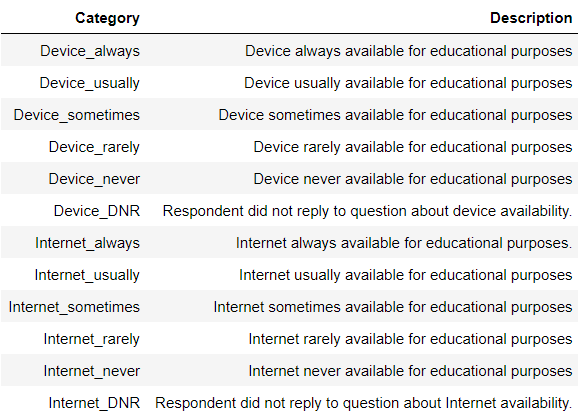

In [43]:
sapply(availability, function(x) sum(is.na(x))) #No missing values

In [44]:
engg <- map_dfr(all_files, read_files)
state_eng <- engg %>%
    left_join(districts)    
state_eng <- state_eng %>%
    group_by(state) %>%
    summarize(Count = n(), 
             engagement_index = mean(engagement_index, na.rm=TRUE),
             pct_access = mean(pct_access, na.rm=TRUE))
state_eng <- na.omit(state_eng)

In [45]:
# 5 States with the fewest observations in the data
state_eng_lowest = head(state_eng[order(state_eng$Count),], 5)
state_eng_lowest

The counts for North Dakota and Arizona are very low and the Engagement Index score is elevated; in combination, this suggests that the mean scores for these states may have been affected by inadequate data sampling. Hence, their data is not included in this analysis, and subsequent analysis involving state mean engagement measure scores will also not include North Dakota and Arizona.

With these states excluded, below are the correlations between the ranked percentage of responses in each state within categories and state mean scores on the engagement index and pct access variables.

In [46]:
state_eng = subset(state_eng, state!="Arizona" & state!="North Dakota") #Removing the states
state_eng_avail <- state_eng %>%
    left_join(availability, by="state")
head(state_eng_avail)

### Correlation test (Spearman's r and Kendall's tau-b)

Checking the correlation between internet/device access and engagement_index and pct_access

In [47]:
mean_eng = state_eng_avail$engagement_index
mean_pct = state_eng_avail$pct_access
state_eng_avail <- subset(state_eng_avail, select=-c(engagement_index, pct_access))

In [48]:
spreng <- c(cor.test(state_eng_avail$Device_always, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_usually, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_sometimes, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_rarely, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_never, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_DNR, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_always, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_usually, mean_eng, method="spearman")$estimate,
            cor.test(state_eng_avail$Internet_sometimes, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_rarely, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_never, mean_eng, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_DNR, mean_eng, method="spearman",exact=FALSE)$estimate
            )
sprpct <- c(cor.test(state_eng_avail$Device_always, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_usually, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_sometimes, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_rarely, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_never, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Device_DNR, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_always, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_usually, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_sometimes, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_rarely, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_never, mean_pct, method="spearman",exact=FALSE)$estimate,
            cor.test(state_eng_avail$Internet_DNR, mean_pct, method="spearman",exact=FALSE)$estimate
            )
cats = c('Device_always', 'Device_usually', 'Device_sometimes', 'Device_rarely', 'Device_never',
         'Device_DNR', 'Internet_always', 'Internet_usually', 'Internet_sometimes', 'Internet_rarely', 'Internet_never',
        'Internet_DNR')
state_eng_avail_results <- data.frame(cats, spreng, sprpct)
names(state_eng_avail_results) <- c('Variable', 'Spearman r (engagement_index)',
                                    'Spearman r (pct_access)')
state_eng_avail_results

***These correlational results support the assumption that without an adequate device or Internet connectivity, there can be no engagement in digital learning.***

### Engagement and Access by Expenditure per Pupil

In [49]:
expndLevelsSimple = c("1" = "0-10K", "2"="0-10K", "3" ="0-10K", "4" ="10K-16K",
              "5"="10K-16K", "6"="10K-16K", "7"="16+K", "8"="16+K",
              "9"="16+K", "10" ="16+K", "11"="16+K")

districtEngAccessMonthly %>%
  filter(!is.na(expenditure)) %>%
  group_by(Expenditure = recode_factor(expenditure, !!!expndLevelsSimple), month) %>%
  summarise(
    Engagement = mean(Engagement, na.rm=T),
    Access = mean(Access, na.rm=T)
  ) %>%
  pivot_longer(cols = c(Engagement, Access), names_to = "Index", values_to = "Value") %>%
  arrange(month) %>%
  ggplot(aes(x=month, y=Value, color=Expenditure, group=Expenditure))+
  geom_point(aes(shape=Expenditure), size=2)+
  geom_line(aes(linetype=Expenditure))+
  labs(
    title = "Engagement and Access by Expenditure per Pupil",
    x = "Month", y="Standardized Value"
  )+
  facet_wrap(~Index, ncol=1)

## Engagement and Access Change Across Products

### Engagement and Access by Product Category

In [50]:
productEngAccessMonthly = products %>%
  left_join(
    engagement %>% filter(!is.na(lp_id)) %>%
      group_by(
        lp_id,
        month = factor(months(time, abbreviate=T), levels = month.abb)
      ) %>%
      summarise(
        eng = mean(engagement_index_scaled, na.rm=T),
        access = mean(pct_access_scaled, na.rm=T),
        size = n()
      ),
    by = "lp_id"
  ) %>%
  filter(eng < 5 & access < 5)

productEngAccessMonthly %>% 
  filter(!is.na(main_fun)) %>%
  group_by(main_fun, month) %>%
  summarise(
    Engagement = mean(eng, na.rm=T),
    Access = mean(access, na.rm=T),
    size = mean(size, na.rm =T)
  ) %>%
  pivot_longer(cols = c(Engagement, Access), names_to = "Index", values_to = "Value") %>%
  mutate(Group = main_fun) %>%
  arrange(month) %>%
  ggplot(aes(x=month, y=Value, color=Group, group=Group))+
  geom_point(aes(shape=Group), size=2)+
  geom_line(aes(linetype=Group))+
  theme(legend.position = "right")+
  labs(
    title="Engagement and Access by Product Category"
  )+
  facet_wrap(~Index, ncol=1, nrow = 2)

# Most popular tools

In [51]:
head(dl)
ep_dl <- dl %>% 
  dplyr::group_by(lp_id, provider_company_name, product_name) %>% dplyr::summarise(cnt_id=n(), .groups="drop") %>% 
  arrange(desc(cnt_id)) %>% filter(!is.na(product_name)) 
ep_top20 <- ep_dl %>% select(provider_company_name, product_name, lp_id) %>% head(20)

In [96]:
head(ep_dl)

In [97]:
head(ep_top20)

### Top 20 Product¶

In [52]:
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

fig(12, 7)
ggplot(data=ep_top20, aes(x=reorder(product_name, lp_id), y=lp_id, fill=product_name)) +
  geom_bar(stat="identity", width=0.9, color="white") +
  geom_text(aes(label=paste0(format(round(as.numeric(lp_id/1000), 1), nsmall=1, big.mark=","),"K")), 
            position=position_stack(vjust=0.9), size=4) +
  scale_x_discrete(guide = guide_axis(angle=45)) +
  labs(title="Top 20 Product") +
  xlab("Product") +
  ylab("Engagement") +
  theme(legend.position = "none", text = element_text(size=15))

### Google Top 20 Product

In [53]:
google_product <- ep_dl %>% filter(provider_company_name==c("Google LLC")) %>% 
    select(lp_id, provider_company_name, product_name, cnt_id) %>% arrange(-cnt_id) %>% head(20)
ggplot(data=google_product, aes(x=reorder(product_name, -cnt_id), y=cnt_id, fill=product_name)) +
  geom_bar(stat="identity", width=0.9, color="white") +
  geom_text(aes(label=paste0(format(round(as.numeric(cnt_id/1000), 1), nsmall=1, big.mark=","),"K")), 
            position=position_stack(vjust=0.9), size=3) +
  scale_x_discrete(guide = guide_axis(angle=45)) +
  labs(title="Google Top 20 Product") +
  xlab("Google Produts") +
  ylab("Engagement") +
  theme(legend.position = "none", text = element_text(size=15))

### Non Google Top 20 Product

In [54]:
non_google_t20 <- ep_dl %>% filter(provider_company_name != "Google LLC") %>% 
  select(lp_id, provider_company_name, product_name, cnt_id) %>% 
  arrange(desc(cnt_id)) %>% head(20)

ggplot(data=non_google_t20, aes(x=reorder(product_name, -cnt_id), y=cnt_id, fill=product_name)) +
  geom_bar(stat="identity", width=0.9, color="white") +
  geom_text(aes(label=paste0(format(round(as.numeric(cnt_id/1000), 1), nsmall=1, big.mark=","),"K")), 
            position=position_stack(vjust=0.9), size=3) +
  scale_x_discrete(guide = guide_axis(angle=45)) +
  labs(title="Non Google Top 20 Product") +
  xlab("Produts") +
  ylab("Engagement") +
  theme(legend.position = "none", text = element_text(size=15))

### Top 20 Digital Learning Platform

In [55]:
fig(12, 8)
dlp_data <- dl %>% filter(sub_fun=="Digital Learning Platforms") %>% 
  dplyr::group_by(lp_id, provider_company_name, product_name, sub_fun) %>% 
  dplyr::summarise(cnt_id=n(), m_pa=mean(pct_access, na.rm=T), m_ei=mean(engagement_index, na.rm=T),.groups="drop") %>% 
  arrange(desc(cnt_id)) 
ep_byproduct_t20 <- dlp_data %>% select(product_name, provider_company_name, cnt_id, m_pa, m_ei) %>% 
    arrange(-cnt_id) %>% head(20)
ggplot(data=ep_byproduct_t20, aes(x=reorder(product_name, -cnt_id), y=cnt_id, fill=product_name)) +
  geom_bar(stat="identity", width=0.9, color="white") +
  geom_text(aes(label=paste0(format(round(as.numeric(cnt_id/1000), 1), nsmall=1, big.mark=","),"K")), 
            position=position_stack(vjust=0.9), size=3) +
  scale_x_discrete(guide = guide_axis(angle=45)) +
  labs(title="Top 20 Digital Learning Platform") +
  xlab("Product") +
  ylab("Engagement") +  
  theme(legend.position = "none", text = element_text(size=15))

In [98]:
fig(12, 8)
x <- subset(products, lp_id==29322) 
lp_idt1 <- dl %>% filter(lp_id==29322) %>% 
  dplyr::group_by(time) %>% dplyr::summarise(cnt_lp=n(), me_pa=mean(pct_access, na.rm=T), me_ei=mean(engagement_index, na.rm=T))
ggplot(data=lp_idt1, aes(x=time, y=cnt_lp, alpha=me_ei)) +
  geom_point() +
  geom_smooth(formula = y ~ x, method="lm", color="blue", alpha=0.2) +
  labs(title=paste("User Engagement of", x$product_name)) +
  xlab("Year 2020") +
  ylab("Number of Engagements") +
  guides(alpha=guide_legend("Engagement Index"))

In [99]:
x <- subset(products, lp_id==90153) 
lp_idt1 <- dl %>% filter(lp_id==90153) %>% 
  dplyr::group_by(time) %>% dplyr::summarise(cnt_lp=n(), me_pa=mean(pct_access, na.rm=T), me_ei=mean(engagement_index, na.rm=T))
ggplot(data=lp_idt1, aes(x=time, y=cnt_lp, alpha=me_ei)) +
  geom_point() +
  geom_smooth(formula = y ~ x, method="lm", color="blue", alpha=0.2) +
  labs(title=paste("User Engagement of", x$product_name)) +
  xlab("Year 2020") +
  ylab("Number of Engagements") +
  guides(alpha=guide_legend("Engagement Index"))

## Mean daily page-load events in top 10/20 Tools by per student, time, location, financial and social features

### Mean daily page-load events in top 20 tools, per 1 student

In [56]:
'%ni%' <- Negate('%in%')

dl %>%
  group_by(product_name) %>%
  summarise(mean = mean(engagement_index, na.rm=TRUE)/1000) %>%
  arrange(desc(mean)) %>%
  slice(1:20) %>%
  mutate(fill = case_when(product_name == "Google Docs" ~ "1",
                          product_name == "Google Classroom" ~ "2",
                          product_name == "YouTube" ~ "3",
                          product_name %ni% c("Google Docs", "Google Classroom", "YouTube") ~ "4")) %>%
ggplot(., aes(reorder(product_name, +mean), mean, fill = fill))+
  geom_bar(col = "gray10", stat = "identity", width = 0.75, alpha = 0.8)+
  scale_colour_brewer(palette = "Paired")+
  coord_flip()+
  labs(title = "Mean daily page-load events in top 20 tools", subtitle = "per 1 student", y = "Mean daily page-load events per one student", 
       x = "Tool")+
  theme(legend.position = "none")

### Mean daily page-load events in top 10 tools by tools and time, per 1 student

In [57]:
dl %>%
  filter(product_name %in% c("Google Docs", "Google Classroom", "YouTube", "Canvas", "Schoology", "Meet", "Kahoot!", "Google Forms", "Google Drive", "ClassLink")) %>%
  group_by(product_name,  time = week(as.Date(time))) %>%
  summarise(mean = mean(engagement_index, na.rm=TRUE)/1000, .groups = "drop") %>%
ggplot(., aes(time, mean, colour = product_name))+
  geom_line(size = 1.2, alpha = 1)+
  scale_colour_brewer(palette = "Paired")+
  labs(title = "Mean daily page-load events in top 10 tools", subtitle = "by tools and time, per 1 student", y = "Mean daily page-load events per one student", 
       x = "Week of year (2020)")+
  theme(legend.position = "right", legend.direction = "vertical")

### Mean daily page-load events in top 10 tools by locale and tools, per 1 student

In [58]:
dl %>%
  filter(locale != "NA") %>%
  filter(product_name %in% c("Google Docs", "Google Classroom", "YouTube", "Canvas", "Meet", "Schoology", "Kahoot!", "Google Forms", "Google Drive", "ClassLink")) %>%
  group_by(product_name, locale) %>%
  summarise(mean = mean(engagement_index, na.rm=TRUE)/1000, .groups = "drop") %>%
  mutate(color = ifelse(mean > 5, "0", "1")) %>%
  arrange(locale) %>%
ggplot(., aes(locale, mean, fill = color))+
  geom_bar(col = "gray10", stat = "identity", width = 0.75, alpha = 0.8)+
  facet_wrap(.~product_name, nrow = 2)+
  scale_colour_brewer(palette = "Paired")+
  scale_y_continuous(breaks = c(0, 5, 10, 15))+
  coord_flip()+
  labs(title = "Mean daily page-load events in top 10 tools", subtitle = "by locale and tools, per 1 student", y = "Mean daily page-load events per one student", 
       x = "Locate")+
  theme(legend.position = "none")

### Mean daily page-load events in top 10 tools by share of black/hispanic students and tools, per 1 student

In [59]:
dl %>%
  filter(pct_black_hispanic != "NA") %>%
  filter(product_name %in% c("Google Docs", "Google Classroom", "YouTube", "Canvas", "Meet", "Schoology", "Kahoot!", "Google Forms", "Google Drive", "ClassLink")) %>%
  group_by(product_name, pct_black_hispanic) %>%
  summarise(mean = mean(engagement_index, na.rm=TRUE)/1000, .groups = "drop") %>%
  mutate(color = ifelse(mean > 5, "0", "1")) %>%
  arrange(pct_black_hispanic) %>%
ggplot(., aes(pct_black_hispanic, mean, fill = color))+
  geom_bar(col = "gray10", stat = "identity", width = 0.75, alpha = 0.8)+
  facet_wrap(.~product_name, nrow = 2)+
  scale_colour_brewer(palette = "Paired")+
  scale_y_continuous(breaks = c(0, 5, 10, 15))+
  coord_flip()+
  labs(title = "Mean daily page-load events in top 10 tools", subtitle = "by share of black/hispanic students and tools, per 1 student", y = "Mean daily page-load events per one student", 
       x = "Share of black/hispanic students")+
  theme(legend.position = "none")

### Mean daily page-load events in top 10 tools by share of students eligible for free or reduced-price lunch and tools, per 1 student

In [60]:
dl %>%
  filter(pct_free_reduced != "NA") %>%
  filter(product_name %in% c("Google Docs", "Google Classroom", "YouTube", "Canvas", "Meet", "Schoology", "Kahoot!", "Google Forms", "Google Drive", "ClassLink")) %>%
  group_by(product_name, pct_free_reduced) %>%
  summarise(mean = mean(engagement_index, na.rm=TRUE)/1000, .groups = "drop") %>%
  mutate(color = ifelse(mean > 5, "0", "1")) %>%
  arrange(pct_free_reduced) %>%
ggplot(., aes(pct_free_reduced, mean, fill = color))+
  geom_bar(col = "gray10", stat = "identity", width = 0.75, alpha = 0.8)+
  facet_wrap(.~product_name, nrow = 2)+
  scale_colour_brewer(palette = "Paired")+
  scale_y_continuous(breaks = c(0, 5, 10, 15))+
  coord_flip()+
  labs(title = "Mean daily page-load events in top 10 tools", subtitle = "by share of students eligible for free or reduced-price lunch and tools, per 1 student", y = "Mean daily page-load events per one student", 
       x = "Students eligible for free or reduced-price lunch")+
  theme(legend.position = "none")


## States Map Data Distribution

A map of USA color coded for the school districts present in the data

In [61]:
# making a map
state_df <- districts %>% 
                group_by(state) %>% 
                tally() %>% 
                right_join(statepop %>% rename(state = full)) %>% 
                replace_na(list(n = 0))

plot_usmap(data = state_df, values = "n") + 
        scale_fill_scico(name = "School districts in dataset", 
                         palette = "davos", direction = -1) +
        theme(legend.position = "bottom",
              legend.text = element_text('Lato', size = 15),
              legend.title =  element_text('Lato', size = 20))

In [62]:
dep_data <- dl %>% filter(!is.na(lp_id) & !is.na(product_name))
dep_product <- dep_data %>% 
  dplyr::group_by(lp_id, provider_company_name, product_name, district_id) %>% 
  dplyr::summarise(cnt_id=n(), nm_pa=mean(pct_access, na.rm=T), nm_ei=mean(engagement_index, na.rm=T), .groups="drop") %>% 
  arrange(desc(cnt_id)) %>% filter(!is.na(product_name))
dep_product <- dep_product %>% filter(!is.na(nm_pa) & !is.na(nm_ei))

nwea_data <- dep_product %>% dplyr::group_by(district_id) %>% dplyr::summarise(cnt_id=sum(cnt_id, na.rm=T), m_pa=mean(nm_pa, na.rm=T), m_ei=mean(nm_ei, na.rm=T))
d_ep <- dep_product %>% left_join(districts, by="district_id")

sd_ep <- d_ep %>% dplyr::group_by(state) %>% 
  dplyr::summarise(s_id=sum(cnt_id), m_pa=mean(nm_pa, na.rm=T), m_ei=mean(nm_ei, na.rm=T), ) %>% 
  filter(state!="NA") %>% 
  arrange(desc(s_id))


In [63]:
library(ggthemes)
states_map <- map_data("state")
sd_ep <- sd_ep %>% mutate(region = tolower(state))
sd_ep_map <- left_join(states_map, sd_ep, by="region")
p0 <- ggplot(data = sd_ep_map,
             mapping = aes(x = long, y = lat,
                           group = group, fill = m_pa))
p1 <- p0 + geom_polygon(color = "gray90", size = 0.1) +
    coord_map(projection = "albers", lat0 = 39, lat1 = 45) 
p1 + labs(title = "Percentage Access by State") + theme_map() + labs(fill = "Pct Access")

In [64]:
p0 <- ggplot(data = sd_ep_map,
             mapping = aes(x = long, y = lat,
                           group = group, fill = m_ei))
p1 <- p0 + geom_polygon(color = "gray90", size = 0.1) +
    coord_map(projection = "albers", lat0 = 39, lat1 = 45) 
# p1 + labs(title = "Pct Access") + theme_map() + labs(fill = "Percent")
p2 <- p1 + scale_fill_gradient(low = "white", high = "#CB454A") +
        labs(title = "Engagement Index per State") 
p2 + theme_map() + labs(fill = "Percent")

### Mean daily page-load events in top 10 tools by every state, per 1 student

In [65]:
dl %>%
  filter(state %in% c("Arizona", "California", "Connecticut", "District Of Columbia", "Florida")) %>%
  filter(product_name %in% c("Google Docs", "Google Classroom", "YouTube", "Canvas", "Meet", "Schoology",
"Kahoot!", "Google Forms", "Google Drive", "ClassLink")) %>%
  group_by(product_name, state) %>%
  summarise(mean = mean(engagement_index, na.rm=TRUE)/1000, .groups = "drop") %>%
  arrange(desc(mean)) %>%
  mutate(color = ifelse(mean > 5, "0", "1")) %>%
ggplot(., aes(reorder(product_name, +mean), mean, fill = color))+
  geom_bar(col = "gray10", stat = "identity", width = 0.75, alpha = 0.8)+
  facet_wrap(.~state)+
  scale_fill_brewer(palette = "Dark2")+
  scale_y_continuous(breaks = c(0, 5, 10, 15, 20))+
  coord_flip()+
  labs(title = "Mean daily page-load events in top 10 tools", subtitle = "by every state, per 1 student", y = "Mean daily page-load events per one student", 
       x = "Tool")+
  theme(legend.position = "none")

In [66]:
dl %>%
  filter(state %in% c("Illinois", "Indiana", "Massachusetts", "Michigan", "Minnesota", "Missouri")) %>%
  filter(product_name %in% c("Google Docs", "Google Classroom", "YouTube", "Canvas", "Meet", "Schoology",
"Kahoot!", "Google Forms", "Google Drive", "ClassLink")) %>%
  group_by(product_name, state) %>%
  summarise(mean = mean(engagement_index, na.rm=TRUE)/1000, .groups = "drop") %>%
  arrange(desc(mean)) %>%
  mutate(color = ifelse(mean > 5, "0", "1")) %>%
ggplot(., aes(reorder(product_name, +mean), mean, fill = color))+
  geom_bar(col = "gray10", stat = "identity", width = 0.75, alpha = 0.8)+
  facet_wrap(.~state)+
  scale_fill_brewer(palette = "Dark2")+
  scale_y_continuous(breaks = c(0, 5, 10, 15, 20))+
  coord_flip()+
  labs(title = "Mean daily page-load events in top 10 tools", subtitle = "by every state, per 1 student", y = "Mean daily page-load events per one student", 
       x = "Tool")+
  theme(legend.position = "none")

In [67]:
dl %>%
  filter(state %in% c("New Hampshire", "New Jersey", "New York", "North Carolina", "North Dakota", "Ohio")) %>%
  filter(product_name %in% c("Google Docs", "Google Classroom", "YouTube", "Canvas", "Meet", "Schoology",
"Kahoot!", "Google Forms", "Google Drive", "ClassLink")) %>%
  group_by(product_name, state) %>%
  summarise(mean = mean(engagement_index, na.rm=TRUE)/1000, .groups = "drop") %>%
  arrange(desc(mean)) %>%
  mutate(color = ifelse(mean > 5, "0", "1")) %>%
ggplot(., aes(reorder(product_name, +mean), mean, fill = color))+
  geom_bar(col = "gray10", stat = "identity", width = 0.75, alpha = 0.8)+
  facet_wrap(.~state)+
  scale_fill_brewer(palette = "Dark2")+
  scale_y_continuous(breaks = c(0, 5, 10, 15, 20))+
  coord_flip()+
  labs(title = "Mean daily page-load events in top 10 tools", subtitle = "by every state, per 1 student", y = "Mean daily page-load events per one student", 
       x = "Tool")+
  theme(legend.position = "none")

In [68]:
dl %>%
  filter(state %in% c("Tennessee", "Texas", "Utah", "Virginia", "Washington", "Wisconsin")) %>%
  filter(product_name %in% c("Google Docs", "Google Classroom", "YouTube", "Canvas", "Meet", "Schoology",
"Kahoot!", "Google Forms", "Google Drive", "ClassLink")) %>%
  group_by(product_name, state) %>%
  summarise(mean = mean(engagement_index, na.rm=TRUE)/1000, .groups = "drop") %>%
  arrange(desc(mean)) %>%
  mutate(color = ifelse(mean > 5, "0", "1")) %>%
ggplot(., aes(reorder(product_name, +mean), mean, fill = color))+
  geom_bar(col = "gray10", stat = "identity", width = 0.75, alpha = 0.8)+
  facet_wrap(.~state)+
  scale_fill_brewer(palette = "Dark2")+
  scale_y_continuous(breaks = c(0, 5, 10, 15, 20))+
  coord_flip()+
  labs(title = "Mean daily page-load events in top 10 tools", subtitle = "by every state, per 1 student", y = "Mean daily page-load events per one student", 
       x = "Tool")+
  theme(legend.position = "none")

# Correlation analysis with Covid-19 cases in 2020

In [69]:
head(dl,3)

In [70]:
df <- subset(dl, select=c(pct_access, engagement_index, minority, frl, expenditure))
df <- df[complete.cases(df), ]
M = cor(df)
testRes = cor.mtest(mtcars, conf.level = 0.95)
corrplot(M,
         p.mat = testRes$p,
         insig = 'p-value',
         pch.col='black',
         method='color',
         tl.cex=1.5) # colorful number

# State practices, policies, and interventions associated with changes in student engagement

### Checking for any changes (improvements, etc.) in the states from early to mid pandemic

In [71]:
week_of_list_early=as.Date(c('2020-04-08', '2020-04-22', '2020-04-29'))
week_of_list_mid=as.Date(c('2020-09-23', '2020-09-30', '2020-10-07'))
week_of_list_both <- c(week_of_list_early, week_of_list_mid)

# loading all engagement data
state_data <- engg %>%
    mutate(week = cut.Date(time, breaks = "1 week", labels = FALSE)) %>%
    arrange(time)
state_data <- state_data %>%
    inner_join(districts)
#Weekly average data - Grouping by week
state_data <- state_data %>%
    group_by(week, state) %>%
    summarize(engagement_index = mean(engagement_index, na.rm=TRUE),
             pct_access = mean(pct_access, na.rm=TRUE))
state_data$date = lubridate::ymd("2020-01-01") + lubridate::weeks(state_data$week - 1)
state_data <- na.omit(state_data)

In [72]:
head(state_data)

In [73]:
state_data_list = filter(state_data, date %in% week_of_list_both)
state_data_df = state_data_list[,1:2]
state_data_df = state_data_df[!duplicated(state_data_df), ]
table(state_data_df$state)

We can see that Minnesota and Texas don't have data available for all 6 week so they will be removed for further analysis

In [74]:
state_data = state_data[!state_data$state=="Minnesota",]
state_data = state_data[!state_data$state=="Texas",] 
state_data = state_data[!state_data$state=="Arizona",] 

In [75]:
earlyState = subset(state_data, date >= '2020-04-01' & date <= '2020-08-10')
midState = subset(state_data, date >= '2020-08-10')

earlyState <- earlyState %>%
    group_by(state) %>%
    summarize (eng_early = mean(engagement_index, na.rm=TRUE), pct_early = mean(pct_access, na.rm=TRUE))

midState <- midState %>%
    group_by(state) %>%
    summarize (eng_mid = mean(engagement_index, na.rm=TRUE), pct_mid = mean(pct_access, na.rm=TRUE))

StateData <- earlyState %>%
    inner_join (midState, by = "state")
StateData$rank_eng_early <- rank(-StateData$eng_early)
StateData$rank_eng_mid <- rank(-StateData$eng_mid)
StateData$rank_pct_early <- rank(-StateData$pct_early)
StateData$rank_pct_mid <- rank(-StateData$pct_mid)
StateData <- StateData[order(StateData$rank_eng_early),]

In [76]:
StateData

We can see some changes in the rankings of the engagement of the states.
Let's see the % changes in the engagement and pct access from early to mid pandemic.

In [77]:
StateData$percent_change_eng <- ((StateData$eng_mid - StateData$eng_early) / StateData$eng_early) * 100 
StateData$percent_change_pct <- ((StateData$pct_mid - StateData$pct_early) / StateData$pct_early) * 100
StateData <- StateData[order(StateData$percent_change_eng, decreasing = TRUE),]
StateData

States like Michigan, Tennessee made huge improvements in their engagement index. On the other hand, states like Wisconsin, New Jersey have had a decrease in the engagement and access. To see if any policies played a role in this, we can check out the state policies for these states.

In [78]:
state_response = read.csv('../input/crpe-covid-state-response-database/2020 Covid State Response Database - Master.csv')
compStates <- subset(state_response, select = c("Indicators", "Wisconsin", "California", "Tennessee", "Michigan"))
compStates[c(1, 25, 26),]

We can see that states which have shown imporvements have clearer instructions for dealing with remote learning during the pandemic.
Some other indicators that point to this improvement.

In [79]:
compStates[c(2,3,7,8,16,18,22),]

# Other state related factors that affect the distance learning

In [80]:
state_covid <- read.csv('../input/selected-data-from-covid-state-policy-database/Selected_State_Policy_Data.csv')
state_covidhealth <- read.csv('../input/kids-first-state-health-data/KidFirstCombinedData.csv')
state_childhoodtrends <- read.csv('../input/state-trends-in-childhood-well-being/StateTrendChildWellBeingData.csv')

In [81]:
head(state_covid)

In [82]:
#Change character date to Date
state_covid$dt_school.emp_eligible_COV_vaccination = as.Date(state_covid$dt_school.emp_eligible_COV_vaccination, format = "%m/%d/%Y")

In [83]:
head(state_covidhealth)

In [84]:
head(state_childhoodtrends)

In [85]:
sapply(state_covid, function(x) sum(is.na(x))) #no missing values

In [86]:
sapply(state_covidhealth, function(x) sum(is.na(x))) #no missing values

In [87]:
sapply(state_childhoodtrends, function(x) sum(is.na(x))) #no missing values

In [88]:
state_combined = state_data %>% group_by(state) %>% summarize (eng_index = mean(engagement_index, na.rm = TRUE),
                                                              pct_acc = mean(pct_access, na.rm = TRUE))
state_combined = subset(state_combined, state!="North Dakota")
state_combined = na.omit(state_combined)
state_combined = state_combined %>% inner_join(state_covid, by = "state")
state_combined = state_combined %>% inner_join(state_covidhealth, by = "state")
state_combined = state_combined %>% inner_join(state_childhoodtrends, by = "state")

state_combined <- replace(state_combined, TRUE, lapply(state_combined, NA2mean)) #Replace missing values with mean

head(state_combined)

In [89]:
ncol(state_combined)

In [90]:
library(taRifx)
state_comb <- japply(state_combined[,5:41], which(sapply(state_combined[,5:41], class)=="character"), as.numeric)
states_combined <- as.data.frame(cbind(state_combined[,1:4], state_comb))
states_combined

In [91]:
sum(sapply(states_combined, function(x) sum(is.na(x))))

In [92]:
states_combined <- replace(states_combined, TRUE, lapply(states_combined, NA2mean)) #Replacing missing values with mean

#### Pearson correlation

In [93]:
names(states_combined)

In [94]:
stateeng = states_combined$eng_index
statepct = states_combined$pct_acc
bannedfm = states_combined$banned_school_fm_mandate_2021
evicini = states_combined$evic_initiation_ban_2020
utilshut = states_combined$util_shutoff_moratorium_2020
medicexp = states_combined$medicaid_expansion
adultfluvax = states_combined$AdultFluVaxRateHighRisk
adultnodoc = round(states_combined$AdultsNotSeeingDrDueToCost, 3)
childfluvax = states_combined$ChildFluVaxRateAllChildren
child6mto4y = states_combined$ChildFluVaxRate6Mos4Yr
child5to12 = states_combined$ChildFluVaxRate5.12
child13to17 = states_combined$ChildFluVaxRate13.17
childwohealthins = states_combined$Percent.of.children.w.o.health.insurance

In [95]:
preng <- c(cor.test(bannedfm, stateeng)$estimate, cor.test(evicini, stateeng)$estimate,
          cor.test(utilshut, stateeng)$estimate, cor.test(medicexp, stateeng)$estimate,
          cor.test(adultfluvax, stateeng)$estimate, cor.test(adultnodoc, stateeng)$estimate,
          cor.test(childfluvax, stateeng)$estimate, cor.test(child6mto4y, stateeng)$estimate,
          cor.test(child5to12, stateeng)$estimate, cor.test(child13to17, stateeng)$estimate,
          cor.test(childwohealthins, stateeng)$estimate)

prpct <- c(cor.test(bannedfm, statepct)$estimate, cor.test(evicini, statepct)$estimate,
          cor.test(utilshut, statepct)$estimate, cor.test(medicexp, statepct)$estimate,
          cor.test(adultfluvax, statepct)$estimate, cor.test(adultnodoc, statepct)$estimate,
          cor.test(childfluvax, statepct)$estimate, cor.test(child6mto4y, statepct)$estimate,
          cor.test(child5to12, statepct)$estimate, cor.test(child13to17, statepct)$estimate,
          cor.test(childwohealthins, statepct)$estimate)

state_chars = c('School face mask mandate ban 2021', 'Eviction initiation ban, 2020', 'Utility Shutoff Moratorium, 2020',
               'Medicaid Expansion State', 'Flu Vaccination Rate, High Risk Adults', 
                'Percent of Adults Who Dont See Doctors Due to Cost', 'Flu Vaccination Rate, All Children',
               'Flu Vaccination Rate, Children Age 6 Months to Four Years', 'Flu Vaccination Rate, Children Age 5-12',
               'Flu Vaccination Rate, Children Age 13-17', 'Children Without Health Insurance, Percent')

state_characs = as.data.frame(cbind(state_chars, preng, prpct))
names(state_characs) = c('State Characteristics', 'Engagement Index', 'Pct Access')
state_characs

# Factors affecting Digital Learning (Null Model)

In [101]:
options(warn=-1)
suppressMessages(library("dplyr"))
library("modeest")

engagement_new <- data.frame(matrix(nrow=0, ncol=5))
colnames(engagement) <- c("district", "time", "max_pct_access", "max_engagement_index")

for (i in 1000:9930){
    file <- paste0("../input/learnplatform-covid19-impact-on-digital-learning/engagement_data/", i, ".csv")
    if (file.exists(file)){
        df1 <- read.csv(file, header=T)
        df1$time <- as.Date(df1$time)

        df1_new <- aggregate(df1[,c("time", "pct_access")], by = list(df1$time), FUN = max, na.rm=TRUE)
        
        df1_new <- df1_new[,c("time", "pct_access")]

        
        df2 <- read.csv(file, header=T)
        df2$time <- as.Date(df2$time)
        df2_new <- aggregate(df2[,c("time", "engagement_index")], by = list(df2$time), FUN = max, na.rm=TRUE)
        df2_new <- df2_new[,c("time", "engagement_index")]
        
        df0 <- cbind(df1_new, df2_new)
        
        district <- data.frame(matrix(as.numeric(i), ncol=1, nrow=nrow(df0)))
        colnames(district) <- c("district")
        district <- i
        df <- cbind(district, df0)
        engagement_new <- rbind(engagement_new, df)
    }
}
engagement_new <- engagement_new[,c(1,2,3,5)]
colnames(engagement_new) <- c( "district","time", "max_pct_access", "max_engagement_index")

# Preparing socio-econimic data on districs - Converting Character to Factor 
districts$locale <- as.factor(districts$locale)
districts$pct_black_hispanic <- as.factor(districts$pct_black_hispanic)
districts$pct_free_reduced <- as.factor(districts$pct_free_reduced)
districts$county_connections_ratio <- as.factor(districts$county_connections_ratio)
districts$pp_total_raw <- as.factor(districts$pp_total_raw)

# Adding district data to engagement dataset 

for (i in 1:nrow(engagement_new)){
    for (j in 1:nrow(districts)){
        if (engagement_new[i, "district"]==districts[j, "district_id"]){
            engagement_new[i, "locale"] <- districts[j, "locale"]
            engagement_new[i, "pct_black_hispanic"] <- districts[j, "pct_black_hispanic"]
            engagement_new[i, "pct_free_reduced"] <- districts[j, "pct_free_reduced"]
            engagement_new[i, "county_connections_ratio"] <- districts[j, "county_connections_ratio"]
            engagement_new[i, "pp_total_raw"] <- districts["pp_total_raw"]
        }
    }
}

In [102]:
head(engagement_new,3)

In [104]:
# Creating a new dataset with mean engagement index calculated for each district
# and then Adding district data to engagement dataset 

engagement_1 <- aggregate(engagement_new$max_pct_access, list(engagement_new$district), FUN=mean, data = engagement_new, na.action=na.omit)
colnames(engagement_1) <- c("district", "mean_engagement_index")

districts_new <- districts[order(districts$district_id),]
districts_new <- districts_new[,c(1,3:7)]
colnames(districts_new) <- c("district", "locale", "pct_black_hispanic", "pct_free_reduced", "county_connections_ratio", "pp_total_raw")
engagement_district <- merge(engagement_1, districts_new, by="district")

In [105]:
#Correcting for missing data and -Inf data (replacing by NA)
engagement_district[is.na(engagement_district$mean_engagement_index)] <- NA
engagement_district[engagement_district=="-Inf"] <- NA
engagement_district[engagement_district=="NaN"] <- NA
engagement_district[engagement_district==""] <- NA

In [106]:
suppressMessages(library(lme4))
suppressMessages(library(lmerTest))
install.packages("merTools")
suppressMessages(library(merTools))

In [107]:
engagement_district_new <- na.omit(engagement_district)
library(ggplot2)
ggplot(aes(mean_engagement_index, district), data=engagement_district_new) +
  geom_point()

In [108]:
m1 <- lmer(mean_engagement_index ~ 1 + (1|locale), data=engagement_district_new)
p1 <- plotREsim(REsim(m1), labs=TRUE)
p1

In [109]:
ranef(m1)
fixef(m1)
confint(m1)

In [110]:
m2 <- lmer(mean_engagement_index ~ 1 + (1|pct_black_hispanic), data=engagement_district_new)
p2 <- plotREsim(REsim(m2), labs=TRUE)
p2

In [111]:
ranef(m2)
fixef(m2)
confint(m2)

In [112]:
m3 <- lmer(mean_engagement_index ~ 1 + (1|pct_free_reduced), data=engagement_district_new)
p3 <- plotREsim(REsim(m3), labs=TRUE)
p3

In [113]:
ranef(m3)
fixef(m3)
confint(m3)

In [114]:
m4 <- lmer(mean_engagement_index ~ 1 + (1|pp_total_raw), data=engagement_district_new)
p4 <- plotREsim(REsim(m4), labs=TRUE)
p4

In [115]:
ranef(m4)
fixef(m4)
confint(m4)

In [116]:
summary(m1)
rand(m1)
summary(m2)
rand(m2)
summary(m3)
rand(m3)
summary(m4)
rand(m4)